# 0. Imports

## 0.1. Importing Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import inflection 

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper Functions

In [2]:
# Função auxiliar:

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams[ 'figure.figsize' ] = [20, 10]
    plt.rcParams[ 'font.size' ] = 20
    
    display( HTML( '<style>.container { width:95% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Suppressing the scientific notation of the metrics

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.2. Loading the Data

In [5]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory = False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory = False )

#Merge of both dataframes:
df_raw = pd.merge( df_sales_raw, df_store_raw, on = 'Store', how = 'left' )

In [6]:
#Verifying the merging:

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
713181,367,1,2013-09-30,4757,533,1,0,0,0,d,c,2640.00,9.00,2012.00,0,NaN,NaN,NaN


In [7]:
df1 = df_raw.copy()

# 1. (Passo 1) Descricao dos Dados

## 1.1. Renaming the columns 

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )  #funcao 'map' faz o mapeamento a partir da funcao 'snakecase' 
                                               #de todas as palavras da lista 'cols_old'.
    
#Reanming the columns:
df1.columns = cols_new

## 1.2. Data Dimensions 

In [9]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )

print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types 

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking the 'NA's  

In [11]:
df1.isna().sum()

#É possível observar que da coluna 'store' até a coluna 'assortment', não existem dados faltantes, ou 'NA's. 
#Entretanto, para as outras colunas, sim! Isso pode variar desde erros manuais na insercao dos dados até 
#características do negócio que definiram a presenca desses dados faltantes. É interessante entender o motivo
#pelo qual esses dados estão como 'NA'.

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Filling in the 'NA' Data

In [12]:
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [13]:
# competition_distance              2642

    #distance in meters to the nearest competitor store.
    
    ##1st Hypothesis: 
    ##2nd Hypothesis: 
    
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )
    

# competition_open_since_month    323348

    #gives the approximate month of the time the nearest competitor was opened.
    
    ##1st Hypothesis: Não existe competidor mais próximo, ou está longe demais, e por isso não existe 
                     #data de abertura para a competicao mais próxima.
    ##2nd Hypothesis: Realmente existe uma competicao próxima (Dentro do range do 'competition_distace'),
                     #porém não se sabe quando a loja abriu.
    
df1['competition_open_since_month'] = df1.apply( lambda x: 
                                                
                                        x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis = 1 )
    

# competition_open_since_year     323348

    #gives the approximate year of the time the nearest competitor was opened
    

    
df1['competition_open_since_year'] = df1.apply( lambda x: 
                                                
                                        x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                        else x['competition_open_since_year'], axis = 1 )


# promo2_since_week               508031

    #describes the calendar week when the store started participating in Promo2.
    ##If the data within 'promo2_since_week' = Na, it means that the store decided not to participate
    ##in the promotion ('promo2'). Hence, there's no info about this.
    

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
                                               
                                               if math.isnan( x['promo2_since_week'] ) 
                                               else x['promo2_since_week'], axis = 1 )

    

#promo2_since_year               508031

    #describes the year when the store started participating in Promo2
    
    
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
                                               
                                               if math.isnan( x['promo2_since_year'] ) 
                                               else x['promo2_since_year'], axis = 1 ) 


# promo_interval                  508031

    #describes the consecutive intervals Promo2 is started, naming the months the promotion is 
    #started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November 
    #of any given year for that store

    
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9: 'Sept', 
              10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo?'] = df1[['promo_interval', 'month_map']].apply( lambda x: 
                                                             
                                                 0 if x['promo_interval'] == 0 else 
                                                 1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                 0, axis = 1 )





In [14]:
df1.sample(10).T

,980738,540635,253302,176690,750818,219485,156133,621713,121376,888358
store,324,646,110,521,94,946,34,329,957,489
day_of_week,6,2,6,1,2,5,5,6,2,5
date,2013-02-02 00:00:00,2014-03-04 00:00:00,2014-12-13 00:00:00,2015-02-23 00:00:00,2013-08-27 00:00:00,2015-01-16 00:00:00,2015-03-13 00:00:00,2013-12-21 00:00:00,2015-04-14 00:00:00,2013-04-26 00:00:00
sales,2136,2819,4061,3384,7835,3679,6370,6047,11296,7081
customers,318,394,510,292,695,485,871,581,1071,639
open,1,1,1,1,1,1,1,1,1,1
promo,0,1,0,0,1,1,0,0,1,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,1,0,0,1,0,0,0,0,0
store_type,a,a,a,d,d,a,c,a,d,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo?                       0
dtype: int64

In [16]:
df1.sample().T

,559387
store,443
day_of_week,6
date,2014-02-15 00:00:00
sales,3282
customers,380
open,1
promo,0
state_holiday,0
school_holiday,0
store_type,d


## 1.6. Changing the Data Types

In [17]:
#It's necessary to change the type of variable of 'competition_open_since_month' e 'competition_open_since_year'

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Statistical Description 

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo?                                int64
dtype: object

### 1.7.1. Numerical Attributes

In [19]:
num_attributes = df1.select_dtypes( include = ['float64','int64'] )  #Only numerical variables
cat_attributes = df1.select_dtypes( exclude = ['float64','int64', 'datetime64[ns]'] )  #Only string variables

In [20]:
# Central Tendency (mean, median)

## Mean:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

## Median:
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
    

# Dispersion (max, min, std, range, skew, kurtosis)

## Standard Deviation:
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T

## Minimum:
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T

## Maximum:
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T

## Range: 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

## Skew:
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

## Kurtosis:
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenating all operations:
metrics = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()

metrics.columns = [ 'Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'StD', 'Skew', 'Kurtosis' ] 

In [21]:
metrics

,Attributes,Min,Max,Range,Mean,Median,StD,Skew,Kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

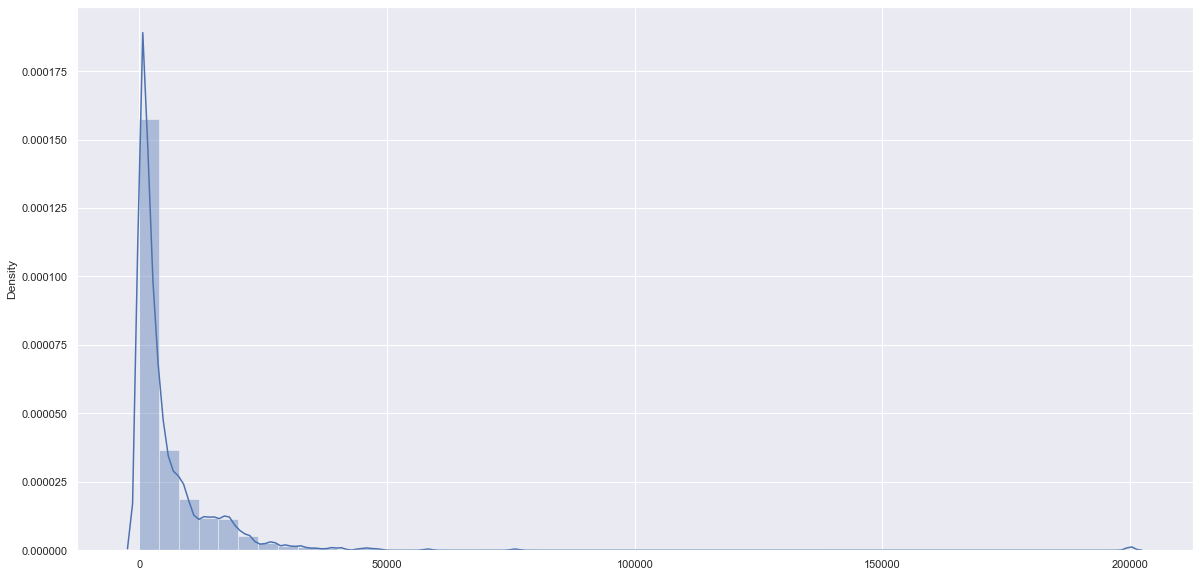

In [22]:
sns.distplot( df1[['competition_distance']] )

### 1.7.2. Categorical Attributes 

In [23]:
# Categorical Attributes, ou variáveis categóricas, são os atributos que são influenciados em funcão da categoria
# pelo qual pertencem. 

In [24]:
cat_attributes.dtypes

state_holiday     object
store_type        object
assortment        object
promo_interval    object
month_map         object
dtype: object

In [25]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo?
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4,2015,0,31,2015,0,Jul,0


In [26]:
# Checking the number of levels which categorical variable possesses:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

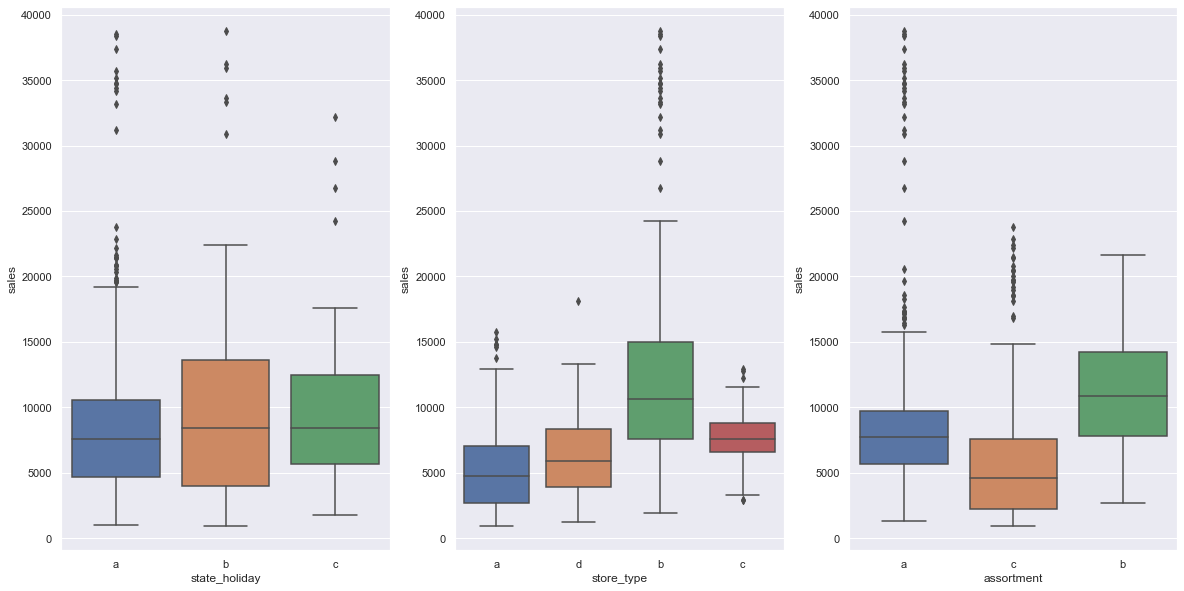

In [27]:
#It's necessary to disregard all sales that are null (= 0). Also, state holidays are not considered.

aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )



In [28]:
# Linha fechada no meio dos quadrados: 50o quartil, ou mediana.
# 

# 2. (Passo 2) Feature Engineering

In [29]:
df2 = df1.copy()

## 2.0. Mind Map Hypothesis

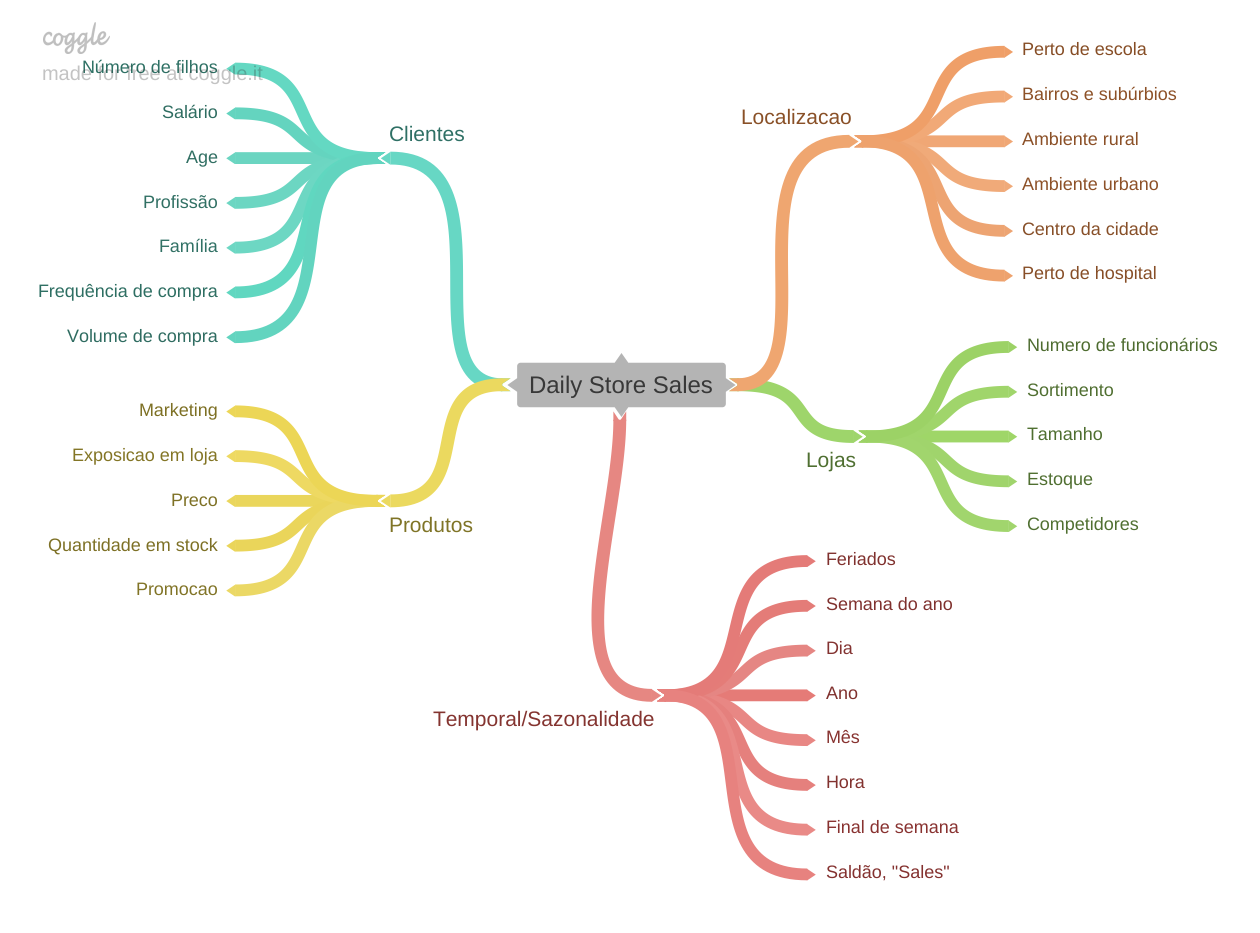

In [30]:
Image( 'Images/MindMapHypothesis.png' )

## 2.1. Creating the Hypothesis

### 2.1.1. Hypothesis for Stores

**1.** Lojas com maior quadro de funcionários vendem 
mais. 

**2.** Lojas com estoque maior deveriam vender mais. 

**3.** Lojas com maior porte deveriam vende mais.  

**4.** Lojas com menor porte deveriam vende menos.  

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo deveriam vender mais (Em comparacão as lojas com competidores a menos tempo).

### 2.1.2. Hypothesis for Products

**1.** Lojas que investem mais em marketing deveriam vender mais. 

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais. 

**3.** Lojas que tem precos menores pros produtos deveriam vender mais.

**4.** Lojas que mantém precos menores pros produtos por mais tempo deveriam vender mais.

**5.** Lojas que promocoes mais agressivas (Descontos maiores) deveriam vender mais.

**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promocao deveriam vender mais.

**8.** Lojas com mais promocoes consecutivas (Em dias consecutivos) deveriam vender mais.

### 2.1.1. Hypothesis for Time (Seasonality)

**1.** Lojas abertas durante os feriados de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos (Quanto mais passa o tempo com uma loja aberta, mais ela vende em comparacao ao ano anterior).

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados  escolares.

## 2.2. Final List of Hypothesis (Priorization)

In [31]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo?'],
      dtype='object')

In [32]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo?
362492,983,2,2014-08-19,10554,1312,1,1,0,1,a,a,40.00,3,2014,1,1,2014,"Jan,Apr,Jul,Oct",Aug,0


**Store Hypothesis**

**1.** - Lojas com maior sortimento deveriam vender mais.

**2.** - Lojas com competidores mais próximos deveriam vender menos.

**3.** - Lojas com competidores a mais tempo deveriam vender mais (Em comparacão as lojas com competidores a menos tempo).

**Products Hypothesis**

**4.** - Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** - Lojas com mais dias de promocao deveriam vender mais.

**6.** - Lojas com mais promocoes consecutivas (Em dias consecutivos) deveriam vender mais.

**Time Hypothesis**

**7.** - Lojas abertas durante os feriados de Natal deveriam vender mais.

**8.** - Lojas deveriam vender mais ao longo dos anos (Quanto mais passa o tempo com uma loja aberta, mais ela vende em comparacao ao ano anterior).

**9.** - Lojas deveriam vender mais no segundo semestre do ano.

**10.** - Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** - Lojas deveriam vender menos aos finais de semana.

**12.** - Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering - Deriving the variables

In [38]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month 

# day
df2['day'] = df2['date'].dt.day 


# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') 


# competition (open) since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], 
                                                                   month = x['competition_open_since_month'], 
                                                                   day = 1 ), axis = 1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w'  ) - 
                                                         datetime.timedelta( days = 9 ) )

df2['promo_since'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype(int) 


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 
    

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' 
                                                            else 'Christimas' if x == 'c' else 'regular_day' )




/tmp/ipykernel_3131/28121033.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [39]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. (Passo 3) Filtragem de Variáveis

In [40]:
df3 = df2.copy()

## 3.0. Check-point da Análise

In [41]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo?,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,extended,1270.00,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,extended,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,extended,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,extended,29910.00,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,0


## 3.1. Filtragem das Linhas

In [42]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Selecão das Colunas

In [43]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )

In [44]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo?', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since'],
      dtype='object')

In [45]:
# Ao final da filtragem das linhas e selecao das colunas, resta apenas o datafram df3, o que representa o conjunto de
# dados importantes a serem utilizados para a análise. Todo o resto diferente é irrelevante e foi desconsiderado a
# partir da funcao 'drop'. 